In [2]:
import sys
sys.path.append('../code')

In [3]:
import cPickle as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [4]:
with open('../data/all_patch_draft_dfs.pkl') as f:
    patch_draft_dfs = pickle.load(f)

In [5]:
df_684 = patch_draft_dfs['6.84']

In [6]:
df_684['avg_pred'] = df_684['predictions'].apply(np.mean)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [8]:
df_684['num_changes'] = df_684['predictions'].apply(np.size)

In [9]:
df_684['predictions'][1]

array([ 0.8069,  0.7242,  0.9359])

In [10]:
df_684.head(3)

,hero,patch,text,text_no_abi,predictions,ratios,pick%,ban%,pb%,times_pb,prev_patch_pb%,prev_patch_winrate,prev_patch_allies,prev_patch_counters,avg_pred,num_changes
0,Abaddon,6.84,[Borrowed Time can now be cast while disabled ...,[can now be cast while disabled (same rules as...,[0.921],[None],1.6,0.6,2.2,34,4.9,0.543,[],[],0.921000,1
1,Alchemist,6.84,[Unstable Concoction:\n\n Countdown can now be...,[:\n\n Countdown can now be seen by enemies\n\...,"[0.8069, 0.7242, 0.9359]","[None, None, None]",1.2,0.3,1.4,22,1.1,0.600,[],[],0.822333,3
2,Ancient Apparition,6.84,[Chilling Touch buff can now be removed by cli...,[buff can now be removed by clicking on the bu...,[0.6837],[None],9.9,15.1,25.0,391,44.3,0.524,"[(Vengeful Spirit, -0.028, False), (Lion, 0.05...","[(Dazzle, 0.124, True), (Shadow Fiend, 0.107, ...",0.683700,1


In [11]:
num_numeric_changes = []
for i, row in df_684.iterrows():
    num_numeric_changes.append(np.sum(np.array(row['ratios']) >= 0))
df_684['num_numeric_changes'] = num_numeric_changes

In [33]:
avg_ratio = []
for ratio_list in df_684['ratios']:
    ratios = np.array(ratio_list)
    mean_ratio = np.mean(ratios[ratios >= 0])
    if type(mean_ratio) in [float, np.float64] and not np.isnan(mean_ratio):
        avg_ratio.append(np.mean(ratios[ratios >= 0]))
    else:
        avg_ratio.append(1)
df_684['avg_ratio'] = avg_ratio

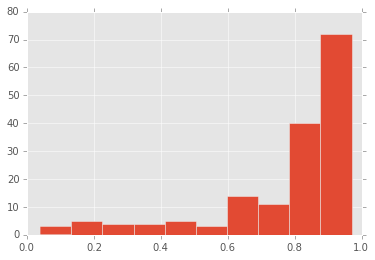

In [22]:
all_preds = []
for item in df_684['predictions']:
    for sub_item in item:
        all_preds.append(sub_item)
_ = plt.hist(all_preds)

In [25]:
num_changes_0_4 = np.zeros(len(df_684))
num_changes_4_6 = np.zeros(len(df_684))
num_changes_6_7 = np.zeros(len(df_684))
num_changes_7_8 = np.zeros(len(df_684))
num_changes_8_9 = np.zeros(len(df_684))
num_changes_9_10 = np.zeros(len(df_684))
for i, pred_list in enumerate(df_684['predictions']):
    for item in pred_list:
        if 0 <= item < 0.4:
            num_changes_0_4[i] += 1
        elif 0.4 <= item < 0.6:
            num_changes_4_6[i] += 1
        elif 0.6 <= item < 0.7:
            num_changes_6_7[i] += 1
        elif 0.7 <= item < 0.8:
            num_changes_7_8[i] += 1
        elif 0.8 <= item < 0.9:
            num_changes_8_9[i] += 1
        elif item >= 0.9:
            num_changes_9_10[i] += 1
        else:
            print 'some item got missed'
df_684['num_changes_0_4'] = num_changes_0_4
df_684['num_changes_4_6'] = num_changes_4_6
df_684['num_changes_6_7'] = num_changes_6_7
df_684['num_changes_7_8'] = num_changes_7_8
df_684['num_changes_8_9'] = num_changes_8_9
df_684['num_changes_9_10'] = num_changes_9_10

In [26]:
pred_dummies = pd.get_dummies(pd.cut(df_684['avg_pred'], [0, 0.4, 0.6, 0.7, 0.8, 0.9, 1.01]), prefix='avg_pred', dummy_na=True)
df_684 = pd.concat([df_684, pred_dummies], axis=1)

In [27]:
composite_ally_change = np.zeros(len(df_684))
composite_counter_change = np.zeros(len(df_684))
for i, row in df_684.iterrows():
    allies = row['prev_patch_allies']
    counters = row['prev_patch_counters']
    for ally in allies:
        ally_pred = df_684[df_684['hero']==ally[0]]['avg_pred'].values[0]
        if ally[1] > 0 and not np.isnan(ally_pred):
            composite_ally_change[i] += ally[1] * ally_pred
    for counter in counters:
        counter_pred = df_684[df_684['hero']==counter[0]]['avg_pred'].values[0]
        if not np.isnan(counter_pred):
            composite_counter_change[i] += counter[1] * counter_pred

df_684['composite_ally_change'] = composite_ally_change
df_684['composite_counter_change'] = composite_counter_change

In [34]:
df_684.head(4).T

,0,1,2,3
hero,Abaddon,Alchemist,Ancient Apparition,Anti-Mage
patch,6.84,6.84,6.84,6.84
text,[Borrowed Time can now be cast while disabled ...,[Unstable Concoction:\n\n Countdown can now be...,[Chilling Touch buff can now be removed by cli...,[]
text_no_abi,[can now be cast while disabled (same rules as...,[:\n\n Countdown can now be seen by enemies\n\...,[buff can now be removed by clicking on the bu...,[]
predictions,[0.921],"[0.8069, 0.7242, 0.9359]",[0.6837],[]
ratios,[None],"[None, None, None]",[None],[]
pick%,1.6,1.2,9.9,9.5
ban%,0.6,0.3,15.1,14.7
pb%,2.2,1.4,25,24.2
times_pb,34,22,391,378


In [39]:
df_test = df_684.copy()
df_test.drop(['hero', 'patch', 'text', 'text_no_abi', 'predictions', 'ratios', 'pick%',
              'ban%', 'times_pb', 'prev_patch_allies', 'prev_patch_counters', 'avg_pred'], axis=1, inplace=True)

In [40]:
target = df_test.pop('pb%').values

In [48]:
X = df_test.values

In [49]:
df_test.head()

,prev_patch_pb%,prev_patch_winrate,num_changes,num_numeric_changes,avg_ratio,num_changes_0_4,num_changes_4_6,num_changes_6_7,num_changes_7_8,num_changes_8_9,num_changes_9_10,"avg_pred_(0, 0.4]","avg_pred_(0.4, 0.6]","avg_pred_(0.6, 0.7]","avg_pred_(0.7, 0.8]","avg_pred_(0.8, 0.9]","avg_pred_(0.9, 1.01]",avg_pred_nan,composite_ally_change,composite_counter_change
0,4.9,0.543,1,0,1.0000,0,0,0,0,0,1,0,0,0,0,0,1,0,0.000000,0.000000
1,1.1,0.600,3,0,1.0000,0,0,0,1,1,1,0,0,0,0,1,0,0,0.000000,0.000000
2,44.3,0.524,1,0,1.0000,0,0,1,0,0,0,0,0,1,0,0,0,0,0.351030,0.046799
3,17.0,0.447,0,0,1.0000,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000
4,72.6,0.474,3,2,1.0415,0,0,0,1,1,1,0,0,0,0,1,0,0,0.144784,-0.070436


In [50]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [47]:
sum(np.isnan(X))

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
df_test['prev_patch_pb%'].fillna(0, inplace=True)
df_test['prev_patch_winrate'].fillna(0, inplace=True)

In [51]:
rf.predict(X)[:20]

array([  3.85 ,   5.834,  31.546,  18.179,  16.461,  13.753,  13.632,
        21.182,  23.787,  40.102,  15.75 ,  28.101,  37.037,  17.58 ,
         2.349,  23.354,  11.846,  56.272,  12.357,  37.627])

In [52]:
target[:20]

array([  2.2,   1.4,  25. ,  24.2,  10.8,  11.7,   5.6,  25.6,  23.1,
        51.3,   7.9,  28.3,  45.5,   9.2,   1.2,  21.9,   9.2,  61.8,
         9.1,  46.7])

In [53]:
df_test['prev_patch_pb%'].values[:20]

array([  4.9,   1.1,  44.3,  17. ,  72.6,   4. ,  77.1,  15.9,   3.1,
         1. ,  40.4,  39. ,  31.8,  12.4,   2.3,  38.8,   1.8,  41.6,
         2.1,   4.2])

In [54]:
from sklearn.metrics import mean_squared_error
mean_squared_error(target, rf.predict(X))

61.418261018518464

In [55]:
mean_squared_error(target, df_test['prev_patch_pb%'])

636.64851851851859

In [56]:
from sklearn.cross_validation import train_test_split

In [57]:
X_train, X_test, y_train, y_test, prev_train, prev_test = train_test_split(X, target, df_test['prev_patch_pb%'].values)

In [58]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [59]:
mean_squared_error(y_test, rf.predict(X_test))

461.49202740740742

In [60]:
mean_squared_error(y_test, prev_test)

940.96481481481476

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [65]:
len(y_test)

27

In [73]:
min_val = 0
min_mse = float('inf')
for const in np.linspace(0, 100, num=1000):
    if mean_squared_error(y_test, [const]*len(y_test)) < min_mse:
        min_val = const
        min_mse = mean_squared_error(y_test, [const]*len(y_test))

In [75]:
min_mse

446.18561459357255

In [76]:
y_test

array([ 21.9,   9.2,  54.4,   2.8,   1.4,   1.2,  28.7,   2.2,   3.7,
         1.8,   3.3,  10.6,  54.1,  45.5,   2. ,   3.3,   0.3,  46. ,
        25.6,  76.3,  10.8,  14.9,  15.5,   3.1,   3.1,  48.2,   2.8])

In [77]:
rf.predict(X_test)

array([ 28.212,   6.608,  58.401,   4.486,  18.812,  39.234,  18.14 ,
         8.332,  25.258,  35.471,  13.664,  16.822,  30.699,  15.787,
        14.895,  19.422,   3.903,  29.785,  23.349,  15.045,  30.241,
        38.238,  31.229,  15.977,  24.324,  16.11 ,   9.546])